In [1]:
import json
import re
import os
from pathlib import Path

import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import torch
import torchvision.transforms.functional as TF
from einops import rearrange
from tifffile import TiffFile
from ome_types import from_tiff, from_xml
from scipy import ndimage as ndi

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mushroom.utils as utils
from mushroom.registration import warp_image, read_bigwarp_warp_field, warp_pts
from mushroom.dataloaders import incorporate_hi_res

In [5]:
run_dir = '/data/estorrs/mushroom/data/test_registration/HT397B1'

In [6]:
metadata = json.load(open(os.path.join(run_dir, 'slices_unregistered', 'metadata.json')))
metadata

{'downsample_scaler': 0.1,
 'phenocycler_pixels_per_micron': 1.9604911906033102,
 'order': ['HT397B1-S1H3A1U1',
  'HT397B1-S1H3A1U2',
  'HT397B1-S1H3A1U12',
  'HT397B1-S1H3A1U21']}

In [7]:
slice_to_sid = {f's{i}':sid for i, sid in enumerate(metadata['order'])}
sid_to_slice = {v:k for k, v in slice_to_sid.items()}
slice_to_sid

{'s0': 'HT397B1-S1H3A1U1',
 's1': 'HT397B1-S1H3A1U2',
 's2': 'HT397B1-S1H3A1U12',
 's3': 'HT397B1-S1H3A1U21'}

In [8]:
fps = sorted(utils.listfiles(os.path.join(run_dir, 'ddfs'),
                             regex=r'/s[0-9]+.*$'))
fps

['/data/estorrs/mushroom/data/test_registration/HT397B1/ddfs/s1.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1/ddfs/s2.tiff',
 '/data/estorrs/mushroom/data/test_registration/HT397B1/ddfs/s3.tiff']

In [11]:
# ddf = read_bigwarp_warp_field(fps[0], metadata['downsample_scaler'])
# ddf.shape, ddf.min(), ddf.max()

In [10]:
slice_to_ddf = {fp.split('/')[-1].split('.')[0]:read_bigwarp_warp_field(
    fp, metadata['downsample_scaler']) for fp in fps}
slice_to_ddf.keys()

dict_keys(['s1', 's2', 's3'])

In [11]:
fps = [
    '/data/spatial_transcriptomics/spaceranger_outputs/breast/HT397B1-S1H3A1U1',
    '/data/spatial_transcriptomics/spaceranger_outputs/breast/HT397B1-S1H3A1U21',
]
sid_to_adata = {fp.split('/')[-1]:utils.adata_from_visium(fp) for fp in fps}

fps = {
    'HT397B1-S1H3A1U1':  '/data/spatial_transcriptomics/highres_images/breast/A1_HT397B1-S1H3A1U1.tif',
    'HT397B1-S1H3A1U21': '/data/spatial_transcriptomics/highres_images/breast/B1_HT397B1-S1H3A1U21.tif',
}

sid_to_he = {sid:fp for sid, fp in fps.items()}
sid_to_he.keys()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


dict_keys(['HT397B1-S1H3A1U1', 'HT397B1-S1H3A1U21'])

In [113]:
a = sid_to_adata['HT397B1-S1H3A1U21'].copy()
he = rearrange(torch.tensor(tifffile.imread(sid_to_he['HT397B1-S1H3A1U21'])), 'h w c -> c h w')
ddf = slice_to_ddf['s3'].clone()

he.shape, a.shape, ddf.shape

(torch.Size([3, 18646, 18378]), (2438, 17943), torch.Size([2, 15730, 15510]))

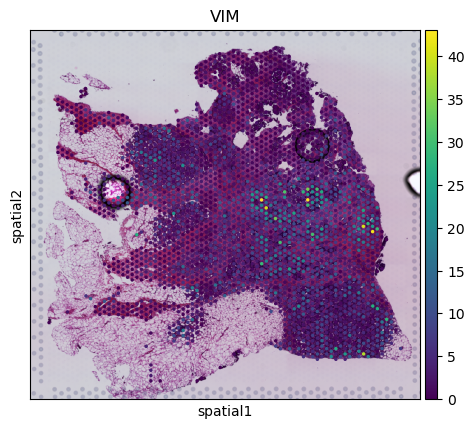

In [114]:
sc.pl.spatial(a, color=['VIM'])

In [115]:
# x = torch.tensor(a.obsm['spatial'])
# x = x[:, [1, 0]]
# transformed, mask = warp_pts(x, ddf)
# display = transformed[mask]

In [116]:
# plt.scatter(x[:, 1], x[:, 0])
# plt.gca().invert_yaxis()
# plt.axis('equal')

In [117]:
a.uns['spatial'].keys()

dict_keys(['HT397B1-S1H3A1U21Bp1'])

In [118]:
next(iter(a.uns['spatial'].values())).keys()

dict_keys(['images', 'scalefactors', 'metadata'])

In [119]:
next(iter(a.uns['spatial'].values()))['images'].keys()

dict_keys(['hires', 'lowres'])

In [120]:
next(iter(a.uns['spatial'].values()))['scalefactors']

{'tissue_hires_scalef': 0.10726161,
 'tissue_lowres_scalef': 0.032178484,
 'fiducial_diameter_fullres': 243.8861211494187,
 'spot_diameter_fullres': 150.97712261630681}

In [121]:
# def get_props(labeled):
#     props = []
#     objects = ndi.find_objects(labeled)
#     print(np.unique(labeled, return_counts=True))
#     plt.imshow(labeled)
#     plt.show()
#     for i, obj in enumerate(objects):
#         if obj is None:
#             continue

#         label = i + 1

#         r1, r2, c1, c2 = obj[0].start, obj[0].stop, obj[1].start, obj[1].stop
#         diam = max(r2 - r1, c2 - c1)
#         print(label, r1, r2, c1, c2, diam)
#         props.append({
#             'label': label,
#             'bbox': (r1, r2, c1, c2),
#             'centroid': (r2 - ((r2 - r1) / 2), c2 - ((c2 - c1) / 2)),
#             'diam': diam
#         })
        
#     return props

In [122]:
def regenerate_adata(he, adata, ddf, phenocycler_pixels_per_micron=1.9604911906033102):
    """
    he - (3, h, w)
    labeled - (1, h, w)
    """
    print('regenerating adata')
    new = adata.copy()
    
    pix_per_micron = next(iter(adata.uns['spatial'].values()))['scalefactors']['spot_diameter_fullres'] / 65.
    scale = 1 / pix_per_micron * phenocycler_pixels_per_micron # bring to codex resolution
    
    d = next(iter(new.uns['spatial'].values()))
    
    scalefactors = d['scalefactors']
    
    hires_size = (int(scalefactors['tissue_hires_scalef'] * he.shape[-2]),
                  int(scalefactors['tissue_hires_scalef'] * he.shape[-1]))
    
    lowres_size = (int(scalefactors['tissue_lowres_scalef'] * he.shape[-2]),
                  int(scalefactors['tissue_lowres_scalef'] * he.shape[-1]))
    
    hires = TF.resize(he, hires_size)
    lowres = TF.resize(he, lowres_size)
    
    d['images']['hires'] = rearrange(hires, 'c h w -> h w c').numpy()
    d['images']['lowres'] = rearrange(lowres, 'c h w -> h w c').numpy()
    print(d['images']['hires'].shape, d['images']['lowres'].shape)
    
    print(scalefactors)

    new.obsm['spatial_original'] = new.obsm['spatial'].copy()
    
    x = (torch.tensor(a.obsm['spatial']) * scale).to(torch.long)
    x = x[:, [1, 0]]
    print(ddf.dtype, x.dtype)
    transformed, mask = warp_pts(x, ddf)
#     new.obsm['spatial'] = transformed[:, [1, 0]].numpy()
    new = new[mask.numpy()]
    new.obsm['spatial'] = transformed[:, [1, 0]].numpy()
        
    d['scalefactors'] = scalefactors
    
    print('adding')
    new.uns['he_fullres'] = rearrange(he.numpy(), 'c h w -> h w c')
    
    return new

def register_adata(he, adata, ddf, phenocycler_pixels_per_micron=1.9604911906033102):
    pix_per_micron = next(iter(adata.uns['spatial'].values()))['scalefactors']['spot_diameter_fullres'] / 65.
    scale = 1 / pix_per_micron * phenocycler_pixels_per_micron # bring to codex resolution
    target = (int(he.shape[-2] * scale), int(he.shape[-1] * scale))
    print(scale, target)

    he = TF.resize(he, target)
    
    adata.uns['he_rescaled'] = rearrange(he, 'c h w -> h w c').numpy()
    adata.obsm['he_rescaled_spatial'] = (adata.obsm['spatial'] * scale).astype(np.int32)
    
    print(he.shape)
    
    warped_he = warp_image(he, ddf)
    
    return warped_he
    
#     new = regenerate_adata(warped_he, adata)
    
#     return new

In [123]:
# new = register_adata(he, a, ddf)
warped_he = register_adata(he, a, ddf)
new = regenerate_adata(warped_he, a, ddf)

0.8440479271357595 (15738, 15511)
torch.Size([3, 15738, 15511])
regenerating adata
(1687, 1663, 3) (506, 499, 3)
{'tissue_hires_scalef': 0.10726161, 'tissue_lowres_scalef': 0.032178484, 'fiducial_diameter_fullres': 243.8861211494187, 'spot_diameter_fullres': 150.97712261630681}
torch.float32 torch.int64
adding


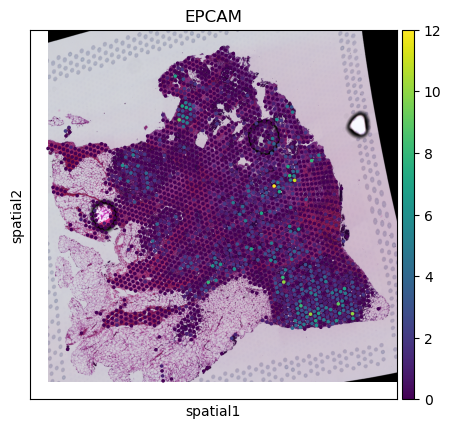

In [124]:
sc.pl.spatial(new, color=['EPCAM'])

## codex

In [12]:
fps = sorted(utils.listfiles('/data/multiplex_imaging/codex/htan/brca', regex=r'ome.tiff$'))
fps

['/data/multiplex_imaging/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff',
 '/data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff']

In [13]:
sid_to_fp = {
    'HT397B1-S1H3A1U2': '/data/multiplex_imaging/codex/htan/brca/031623_BRCA_HT397B1-U2/level_2/HT397B1_U2_03162023.ome.tiff',
    'HT397B1-S1H3A1U12': '/data/multiplex_imaging/codex/htan/brca/03172023_BRCA_HT397B1-U12/level_2/HT397B1_U12_03172023.ome.tiff'
}

channels = ['DAPI', 'Pan-Cytokeratin', 'CD45 (D)', 'SMA-(D)']

sid_to_ome = {}
for k, v in sid_to_fp.items():
    print(k)
    d = utils.extract_ome_tiff(v, channels=channels)
    sid_to_ome[k] = d

HT397B1-S1H3A1U2


/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


HT397B1-S1H3A1U12


In [14]:
ddf = slice_to_ddf['s1']
channel_to_img = sid_to_ome['HT397B1-S1H3A1U2']

In [15]:
def register_codex(channel_to_img, ddf):
    warped_channel_to_img = {c:warp_image(img, ddf) for c, img in channel_to_img.items()}
    
    return warped_channel_to_img

In [16]:
warped_channel_to_img = register_codex(channel_to_img, ddf)

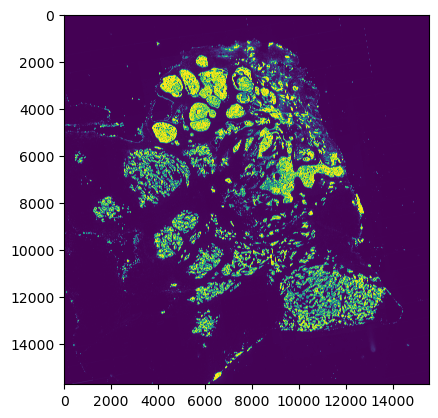

In [17]:
plt.imshow(warped_channel_to_img['Pan-Cytokeratin'])

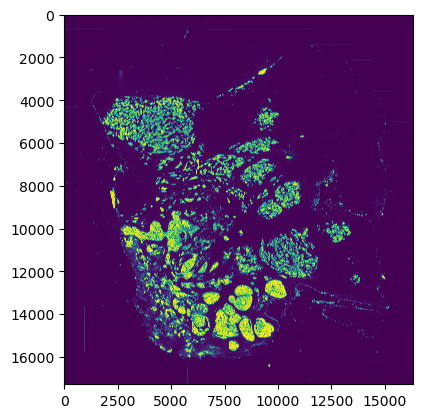

In [18]:
moving = channel_to_img['Pan-Cytokeratin']
plt.imshow(moving)

In [22]:
utils.save_ome_tiff(warped_channel_to_img, '/data/estorrs/sandbox/mushroom/data/test.ome.tiff')

In [23]:
d = utils.extract_ome_tiff('/data/estorrs/sandbox/mushroom/data/test.ome.tiff')
d.keys()

/data/estorrs/miniconda3/envs/mushroom/lib/python3.10/site-packages/ome_types/_convenience.py:106: FutureWarning: The default XML parser will be changing from 'xmlschema' to 'lxml' in version 0.4.0.  To silence this warning, please provide the `parser` argument, specifying either 'lxml' (to opt into the new behavior), or'xmlschema' (to retain the old behavior).
  d = to_dict(os.fspath(xml), parser=parser, validate=validate)


dict_keys(['DAPI', 'Pan-Cytokeratin', 'SMA-(D)', 'CD45 (D)'])

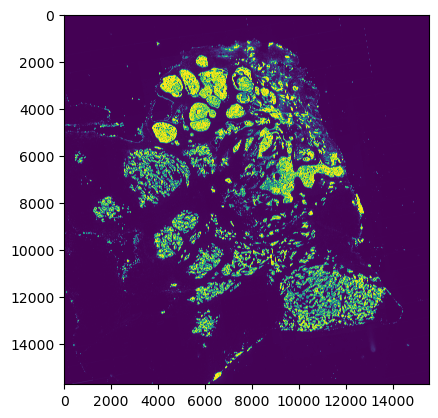

In [24]:
plt.imshow(d['Pan-Cytokeratin'])